In [50]:
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize


In [4]:
# GradCAM++ class definition
class GradCAMPlusPlus:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.grad_model = tf.keras.models.Model(
            inputs=[self.model.inputs], 
            outputs=[self.model.get_layer(target_layer).output, self.model.output]
        )

    def compute_heatmap(self, img_array, class_idx=None):
        with tf.GradientTape() as tape:
            conv_outputs, predictions = self.grad_model(img_array)
            if class_idx is None:
                class_idx = np.argmax(predictions[0])
            loss = predictions[:, class_idx]

            # Compute gradients
            grads = tape.gradient(loss, conv_outputs)

            # Compute weight coefficients for GradCAM++
            grads = grads[0]
            conv_outputs = conv_outputs[0]
            alpha_num = grads**2
            alpha_denom = grads**2 * 2 + tf.reduce_sum(conv_outputs * grads**3, axis=(0, 1))
            alpha_denom = tf.where(alpha_denom != 0.0, alpha_denom, tf.ones_like(alpha_denom))
            alpha = alpha_num / alpha_denom

            weights = tf.reduce_sum(alpha * tf.maximum(grads, 0), axis=(0, 1))

            # Weighted sum of activation maps
            cam = np.zeros(conv_outputs.shape[0:2], dtype=np.float32)
            for i, w in enumerate(weights):
                cam += w * conv_outputs[:, :, i]

            cam = np.maximum(cam, 0)
            heatmap = cam / np.max(cam)  # Normalize
        return heatmap

In [5]:
# Function to preprocess image
def preprocess_image(image_path):
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(224, 224))
    img = tf.keras.preprocessing.image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = tf.keras.applications.vgg16.preprocess_input(img)
    return img

In [51]:
# Function to display GradCAM++ heatmap
def display_gradcam(img_path, heatmap, alpha=0.5):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    superimposed_img = heatmap * alpha + img
    superimposed_img = np.uint8(superimposed_img)
    superimposed_img=cv2.cvtColor(superimposed_img,cv2.COLOR_RGB2BGR)

    # Create a figure with 2 subplots (original image and heatmap)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

    # Title for the entire figure
    fig.suptitle("GradCAM++ Visualization", fontsize=16)

    # Display the original image
    ax1.imshow(img)
    ax1.set_title("Original Image")
    ax1.axis('off')

    # Display the heatmap image
    heatmap_img = ax2.imshow(superimposed_img)
    ax2.set_title("GradCAM++ Heatmap")
    ax2.axis("off")

    # Create a colorbar for the heatmap
    # Normalize the heatmap values between 0 and 255 for the color bar
    norm = Normalize(vmin=0, vmax=255)
    sm = ScalarMappable(cmap='jet', norm=norm)
    sm.set_array([])  # Dummy array for color bar
    plt.colorbar(sm, ax=ax2, fraction=0.046, pad=0.04)

    # Show the figure
    plt.show()

In [8]:
# Load pre-trained ResNet50 model
model = tf.keras.applications.ResNet50(weights='imagenet')

# Specify target layer (last convolutional layer)
target_layer = 'conv5_block3_out'

# Initialize GradCAM++
gradcam_plus_plus = GradCAMPlusPlus(model, target_layer)

In [18]:
# Path to the image
img_path = 'E:\\Study\\SEM 7\\xai\\Project\\vlcsnap-2024-08-21-15h32m14s163_2.png'  # Replace with the path to your image

In [19]:
# Preprocess image
img_array = preprocess_image(img_path)

# Generate heatmap
heatmap = gradcam_plus_plus.compute_heatmap(img_array)

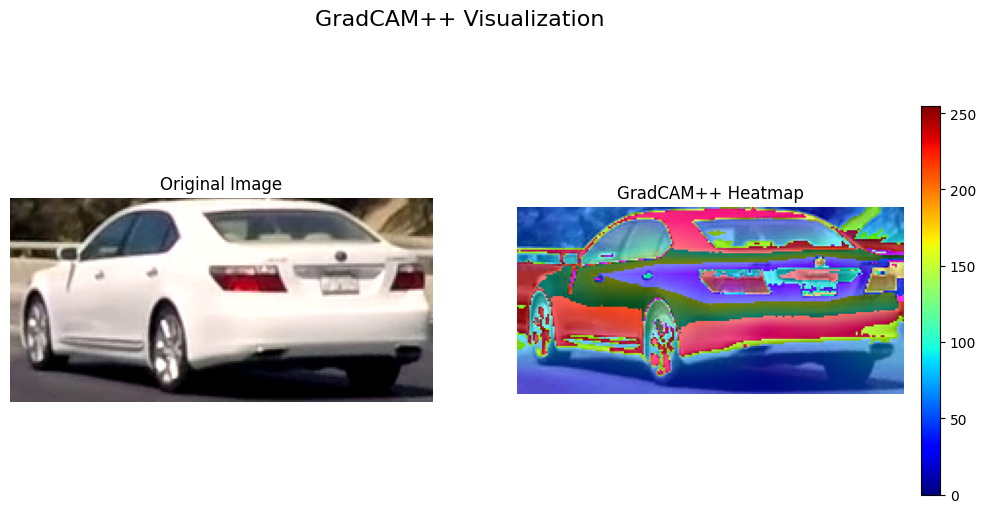

In [52]:
# Display GradCAM++ heatmap superimposed on the original image
display_gradcam(img_path, heatmap)

In [61]:

from scipy.stats import entropy

In [62]:
# Helper function to calculate sparsity
def calculate_sparsity(heatmap, threshold=0.5):
    # Threshold the heatmap: count the number of pixels above the threshold
    sparse_pixels = np.sum(heatmap > threshold)
    total_pixels = heatmap.size
    sparsity = sparse_pixels / total_pixels
    return sparsity

In [63]:
# Helper function to calculate variance
def calculate_variance(heatmap):
    return np.var(heatmap)

In [64]:
# Helper function to calculate entropy
def calculate_entropy(heatmap):
    # Flatten the heatmap and normalize it
    flat_heatmap = heatmap.flatten()
    flat_heatmap = flat_heatmap / np.sum(flat_heatmap)  # Normalize
    # Calculate the entropy
    return entropy(flat_heatmap)

In [65]:
# Function to compute ambiguity metrics
def calculate_ambiguity_metrics(heatmap, method_name):
    print(f"Ambiguity metrics for {method_name}:")

    # Sparsity
    sparsity = calculate_sparsity(heatmap)
    print(f"Sparsity: {sparsity:.4f}")

    # Variance
    var = calculate_variance(heatmap)
    print(f"Variance: {var:.4f}")

    # Entropy
    ent = calculate_entropy(heatmap)
    print(f"Entropy: {ent:.4f}")
    print("-" * 30)

In [66]:
# Function to compute fidelity metrics
def calculate_fidelity_metrics(heatmap, method_name):
    print(f"Fidelity metrics for {method_name}:")

    # Example metric: Mean Activation
    mean_activation = heatmap.mean()
    print(f"Mean Activation: {mean_activation:.4f}")

    # Example metric: Max Activation
    max_activation = heatmap.max()
    print(f"Max Activation: {max_activation:.4f}")

    print("-" * 30)

In [67]:
# Function to compute interpretability metrics
def calculate_interpretability_metrics(heatmap, method_name):
    print(f"Interpretability metrics for {method_name}:")

    # Example metric: Simplicity (measured inversely by the number of non-zero regions)
    non_zero_regions = (heatmap > 0).sum()
    simplicity = 1 / non_zero_regions if non_zero_regions > 0 else None

    # Print simplicity in decimal form
    if simplicity is not None:
        print(f"Simplicity: {simplicity:.12f}")  # Adjust the number of decimal places as needed
    else:
        print("Simplicity: Undefined (No non-zero regions)")



    # Example metric: Saliency Ratio (ratio of maximum value to sum of values)
    saliency_ratio = heatmap.max() / heatmap.sum()
    print(f"Saliency Ratio: {saliency_ratio:.4f}")

    print("-" * 30)

In [68]:
# Calculate fidelity and interpretability metrics for Grad-CAM++
gradcam_ambiguity=calculate_ambiguity_metrics(heatmap, "Grad-CAM++")
gradcam_fidelity = calculate_fidelity_metrics(heatmap, "Grad-CAM++")
gradcam_interpretability = calculate_interpretability_metrics(heatmap, "Grad-CAM++")

Ambiguity metrics for Grad-CAM++:
Sparsity: 0.2245
Variance: 0.0463
Entropy: 3.7400
------------------------------
Fidelity metrics for Grad-CAM++:
Mean Activation: 0.3699
Max Activation: 1.0000
------------------------------
Interpretability metrics for Grad-CAM++:
Simplicity: 0.020408163265
Saliency Ratio: 0.0552
------------------------------
